## Overview 

**This script performs EDA and then preprocesses the dataset to train a bidirectional LSTM model which is in turn used to predict the sentiments behind post and classify them as positive negative or neutral.**



## Installing and importing dependencies

In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis


### Cleaning and prepping dataset


In [55]:
# Load Tweet dataset
df1 = pd.read_csv('/kaggle/input/post-data-x1/Pst data - Copy of Set of work 2 - Sheet1.csv.csv')
# Output first five rows
df1.head()

,clean_post,category
0,My brother in-law (Sammy) lost his home shortl...,-1.0
1,Iâve enjoyed reading and posting on this sub...,0.0
2,"I'm back like I said I would be,. My [original...",-1.0
3,I'll try to keep this short. I had a [1967 Imp...,-1.0
4,I want to sincerely thank everyone who comment...,-1.0


In [56]:
df = pd.concat([df1], ignore_index=True)

In [57]:
# Check for missing data
df.isnull().sum()

clean_post    1
category      0
dtype: int64

In [58]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [59]:
# dimensionality of the data
df.shape

(12847, 2)

In [60]:
# Map post categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# Output first five rows
df.head(10)

,clean_post,category
0,My brother in-law (Sammy) lost his home shortl...,Negative
1,Iâve enjoyed reading and posting on this sub...,Neutral
2,"I'm back like I said I would be,. My [original...",Negative
3,I'll try to keep this short. I had a [1967 Imp...,Negative
4,I want to sincerely thank everyone who comment...,Negative
5,I am a high schooler with a weekend job at a c...,Positive
6,"Hello, everyone. First of all, thank you all f...",Negative
7,"Note. My step-daughter, Madeline, was about a ...",Neutral
8,We had a family dinner this evening. My family...,Negative
9,Iâve become frustrated with how quick a lot ...,Positive


## Exploratory Data Analysis

Data Visualisation-

In [61]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

Plotting the distribution of post lengths

In [62]:
# Calculate post lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_post']])

# The distribution of post text lengths
tweet_len.plot(kind='line')

Plotting the distribution of text length for positive sentiment post

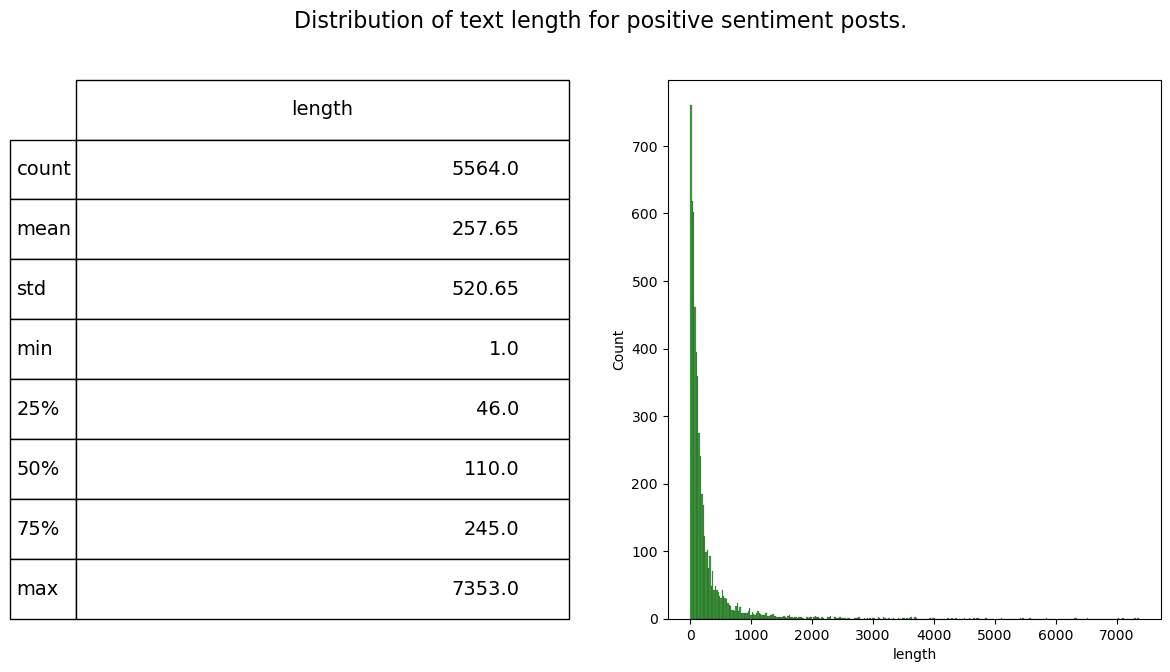

In [63]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_post.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment posts.', fontsize=16)

plt.show()

Plotting the Distribution of text length for Negative sentiment posts.

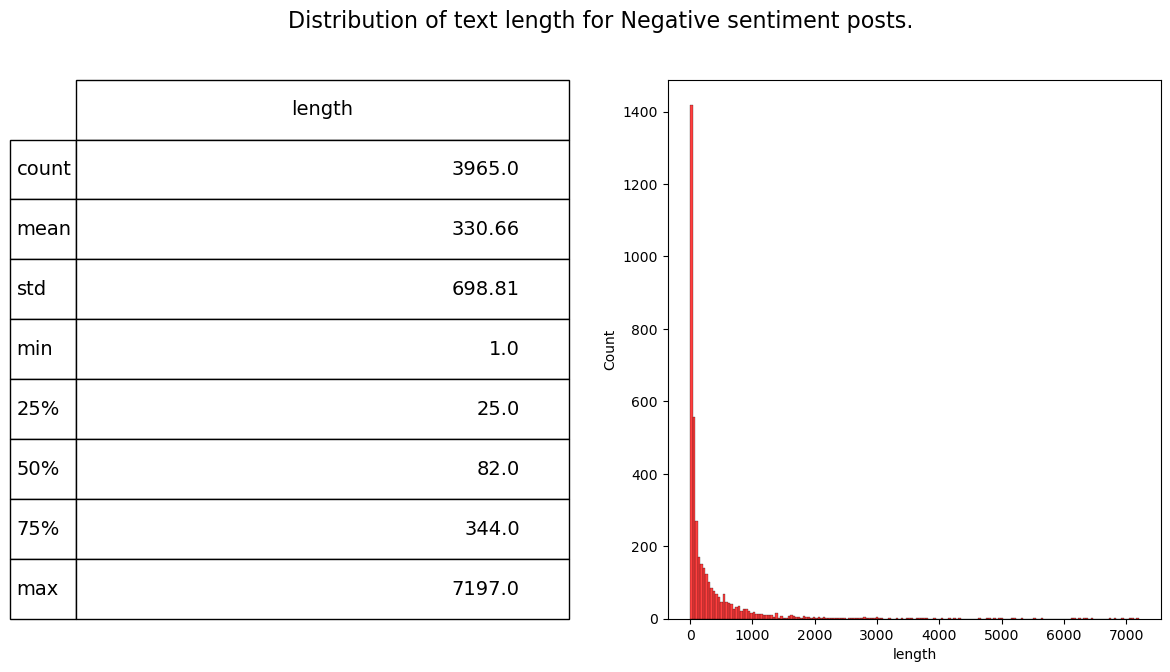

In [64]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_post.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment posts.', fontsize=16)

plt.show()


Plotting the Pie chart of the percentage of different sentiments of all the posts

In [65]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of posts')
fig.show()

In [66]:
df.drop(['length'], axis=1, inplace=True)
df['clean_post'] = df['clean_post'].str.lower()
df.head

<bound method NDFrame.head of                                               clean_post  category
0      my brother in-law (sammy) lost his home shortl...  Negative
1      iâve enjoyed reading and posting on this sub...   Neutral
2      i'm back like i said i would be,. my [original...  Negative
3      i'll try to keep this short. i had a [1967 imp...  Negative
4      i want to sincerely thank everyone who comment...  Negative
...                                                  ...       ...
12843  every channel showing different numbers what t...  Negative
12844  regardless who won bit pathetic that lalu emer...  Negative
12845  let get over with least will live peace for so...  Negative
12846  holy cow fucking fuck bjp jdu 171 paraphrase s...  Negative
12847  manjhi such tool nitish was idiot have given h...  Negative

[12847 rows x 2 columns]>

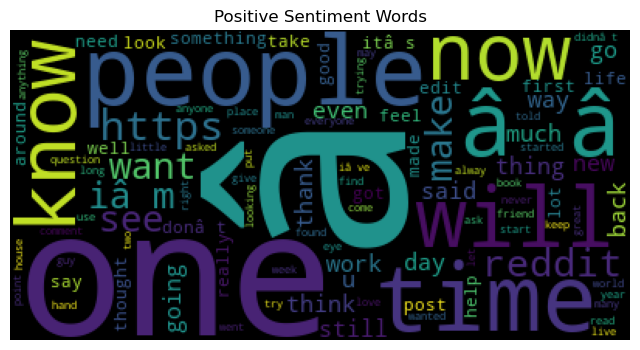

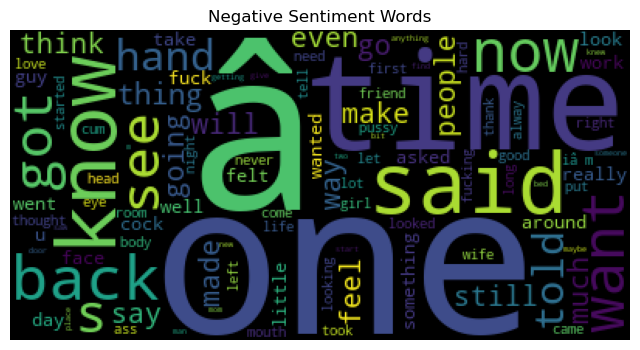

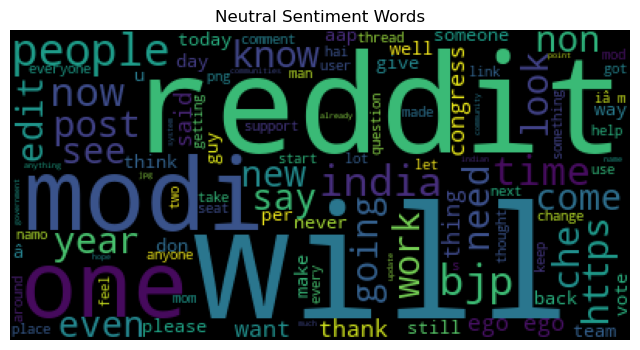

In [67]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: posts dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_posts = " ".join([post for post in df[df.category==category]['clean_post']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='Black', 
                   max_words=100, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(8,8))
    plt.imshow(wc.generate(combined_posts))
    plt.title('{} Sentiment Words'.format(category), fontsize=12)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 'Positive')
     
# Negative tweet words
wordcount_gen(df, 'Negative')
     
# Neutral tweet words
wordcount_gen(df, 'Neutral')
     


## Data Preprocessing

In [68]:
def post_to_words(post):
    ''' Convert post text into a sequence of words '''
    
    # convert to lowercase
    text = post.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal post ->", df['clean_post'][0])
print("\nProcessed post ->", post_to_words(df['clean_post'][0]))


Original post -> my brother in-law (sammy) lost his home shortly after his divorce 10 months ago. he moved in with us and brought his twin daughters (olivia & sloane18) with him a couple of months ago.
his sister (my wife) and i have one daughter (zoey 16) and she and her cousins aren't close but get along fine.

olivia & sloane have no respect for zoey's privacy, none. they used to walk into her room and take everything they get their hands on. makeup, phone accessories, clothes, school laptop etc. zoey complained a lot and i've already asked the girls to respect zoey's privacy and stop taking things. my wife and sammy saw no issue with this. after all, they're girls and this's typical teenage girls behavior. i completely disagreed. 

last straw was when zoey bought a 60$ m.a.c makeup-kit that looks like a paintset that she saved up for over a month and one of the girls, sloane took it without permission and ruined it by mixing shades together while using it. don't know much about ma

In [69]:
# Apply data processing to each post
X = list(map(post_to_words, df['clean_post']))

In [70]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [71]:
print(X[0])
print(Y[0])

['brother', 'law', 'sammi', 'lost', 'home', 'shortli', 'divorc', '10', 'month', 'ago', 'move', 'us', 'brought', 'twin', 'daughter', 'olivia', 'sloane18', 'coupl', 'month', 'ago', 'sister', 'wife', 'one', 'daughter', 'zoey', '16', 'cousin', 'close', 'get', 'along', 'fine', 'olivia', 'sloan', 'respect', 'zoey', 'privaci', 'none', 'use', 'walk', 'room', 'take', 'everyth', 'get', 'hand', 'makeup', 'phone', 'accessori', 'cloth', 'school', 'laptop', 'etc', 'zoey', 'complain', 'lot', 'alreadi', 'ask', 'girl', 'respect', 'zoey', 'privaci', 'stop', 'take', 'thing', 'wife', 'sammi', 'saw', 'issu', 'girl', 'typic', 'teenag', 'girl', 'behavior', 'complet', 'disagre', 'last', 'straw', 'zoey', 'bought', '60', 'c', 'makeup', 'kit', 'look', 'like', 'paintset', 'save', 'month', 'one', 'girl', 'sloan', 'took', 'without', 'permiss', 'ruin', 'mix', 'shade', 'togeth', 'use', 'know', 'much', 'makeup', 'zoey', 'said', 'found', 'kit', 'bed', 'cri', 'told', 'wife', 'said', 'ask', 'sloan', 'apolog', 'got', 'zoe

In [72]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Posts have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

#import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
#X_train = pr.normalize(X_train, axis=1)
#X_test  = pr.normalize(X_test, axis=1)

# print first 200 words/tokens
print(count_vector.get_feature_names_out()[0:200])



/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



['0' '00' '000' '01' '02' '03' '04' '05' '06' '07' '08' '09' '0iti' '1'
 '10' '100' '1000' '101' '10k' '11' '11k' '12' '13' '14' '15' '150' '16'
 '17' '18' '19' '1k' '1st' '2' '20' '200' '2000' '2007' '2008' '2011'
 '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019' '2020' '2021'
 '2022' '20th' '21' '22' '23' '24' '25' '250' '26' '27' '28' '29' '2nd'
 '3' '30' '300' '30pm' '31' '32' '33' '34' '35' '36' '37' '38' '39' '3d'
 '3rd' '4' '40' '400' '401k' '41' '42' '420' '43' '44' '45' '46' '47' '48'
 '4th' '5' '50' '500' '55' '5k' '5th' '6' '60' '600' '65' '66a' '69' '6th'
 '7' '70' '700' '75' '8' '80' '800' '85' '89' '9' '90' '911' '95' '99'
 'aap' 'aaron' 'ab' 'aba' 'abaddon' 'abandon' 'abbi' 'abil' 'abl' 'abort'
 'abroad' 'abruptli' 'absenc' 'absolut' 'absorb' 'absurd' 'abus' 'academ'
 'acceler' 'accent' 'accept' 'access' 'accid' 'accident' 'accommod'
 'accompani' 'accomplish' 'accord' 'account' 'accumul' 'accur' 'accus'
 'accustom' 'ace' 'ach' 'achiev' 'acid' 'acknowledg' 'acquain

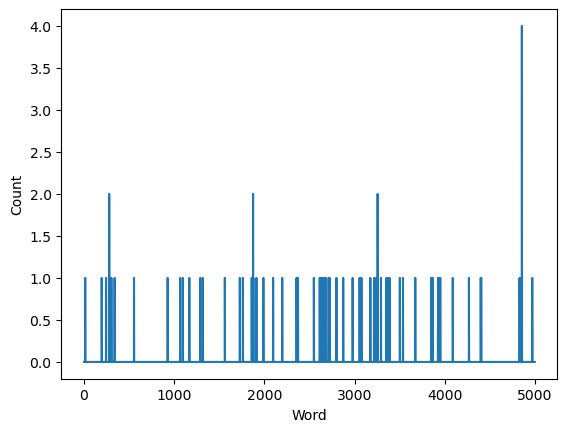

In [74]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Tokenizing & Padding

In [75]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_post'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_post'])
print('After Tokenization & Padding \n', X[0])




Before Tokenization & Padding 
 my brother in-law (sammy) lost his home shortly after his divorce 10 months ago. he moved in with us and brought his twin daughters (olivia & sloane18) with him a couple of months ago.
his sister (my wife) and i have one daughter (zoey 16) and she and her cousins aren't close but get along fine.

olivia & sloane have no respect for zoey's privacy, none. they used to walk into her room and take everything they get their hands on. makeup, phone accessories, clothes, school laptop etc. zoey complained a lot and i've already asked the girls to respect zoey's privacy and stop taking things. my wife and sammy saw no issue with this. after all, they're girls and this's typical teenage girls behavior. i completely disagreed. 

last straw was when zoey bought a 60$ m.a.c makeup-kit that looks like a paintset that she saved up for over a month and one of the girls, sloane took it without permission and ruined it by mixing shades together while using it. don't know

### Saving tokenized data 

In [76]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Train & Test Split

In [77]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (7707, 50) (7707, 3)
Validation Set -> (2570, 50) (2570, 3)
Test Set -> (2570, 50) (2570, 3)


In [78]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Bidirectional LSTM Using NN

In [79]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=30
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

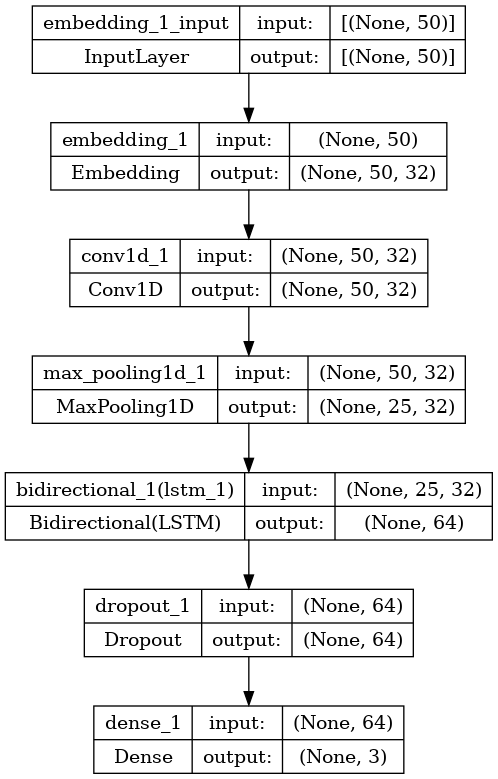

In [80]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [81]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model
#num_epochs = 8
batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                

### Model Accuracy & Loss

In [82]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8082
Precision : 0.8098
Recall    : 0.8070
F1 Score  : 0.8084


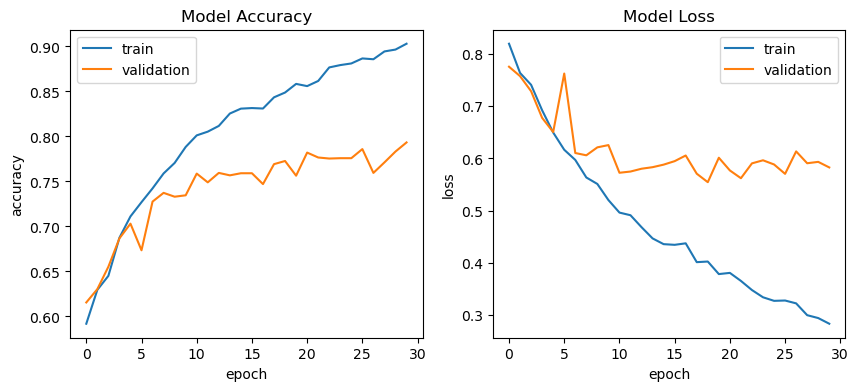

In [83]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

### Model Confusion Matrix

81/81 [==============================] - 1s 3ms/step


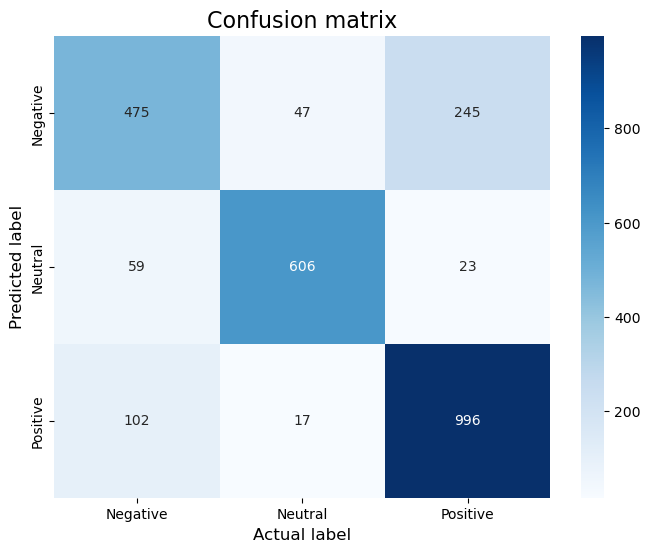

In [84]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

### Model save and load for the prediction

In [85]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [86]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [96]:
predict_class(['A woman was killed by car, blood over street Dhanmondi area yesterday evening'])

1/1 [==============================] - 0s 19ms/step
The predicted sentiment is Negative


In [104]:
predict_class([' this resurent was dfdfsfsf'])

1/1 [==============================] - 0s 19ms/step
The predicted sentiment is Neutral


In [102]:
predict_class(['Finally, some good news for the economy That Bangladeshs merchandise export earnings have crossed the milestone of $50 billion for the second consecutive year is a notable achievement indeed'])

1/1 [==============================] - 0s 33ms/step
The predicted sentiment is Positive


**Result Showing**

In [90]:
from sklearn.metrics import classification_report

# Obtain predictions from the model
y_pred = model.predict(X_test)

# Convert predictions to categorical labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test labels to categorical labels
y_test_labels = np.argmax(y_test.values, axis=1)

# Generate classification report
report = classification_report(y_test_labels, y_pred_labels)

# Print the classification report
print(report)


81/81 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       767
           1       0.90      0.88      0.89       688
           2       0.79      0.89      0.84      1115

    accuracy                           0.81      2570
   macro avg       0.81      0.80      0.80      2570
weighted avg       0.81      0.81      0.80      2570



In [91]:
from sklearn.metrics import classification_report

# Obtain predictions from the model
y_train_pred = model.predict(X_train)

# Convert predictions to categorical labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Convert one-hot encoded training labels to categorical labels
y_train_labels = np.argmax(y_train.values, axis=1)

# Generate classification report
train_report = classification_report(y_train_labels, y_train_pred_labels)

# Print the classification report for the training set
print(train_report)


241/241 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      2355
           1       0.98      0.98      0.98      2004
           2       0.86      0.97      0.91      3348

    accuracy                           0.91      7707
   macro avg       0.93      0.90      0.91      7707
weighted avg       0.91      0.91      0.91      7707



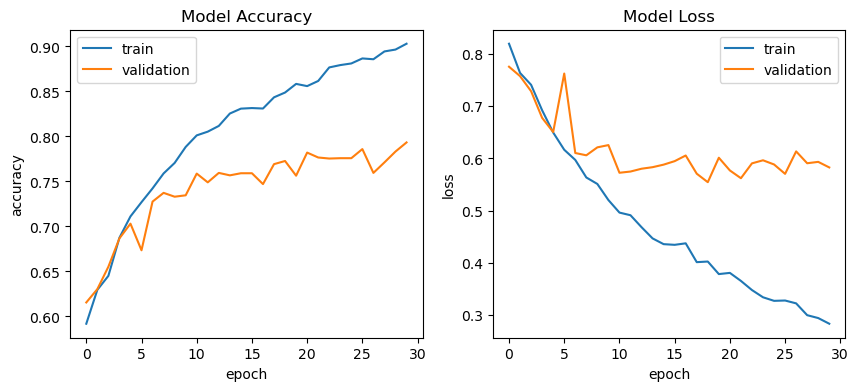

In [92]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [93]:
from sklearn.metrics import classification_report

# Obtain predictions from the model
y_pred = model.predict(X_test)

# Convert predictions to categorical labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test labels to categorical labels
y_test_labels = np.argmax(y_test.values, axis=1)

# Generate classification report
report = classification_report(y_test_labels, y_pred_labels)

# Print the classification report
print(report)


81/81 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       767
           1       0.90      0.88      0.89       688
           2       0.79      0.89      0.84      1115

    accuracy                           0.81      2570
   macro avg       0.81      0.80      0.80      2570
weighted avg       0.81      0.81      0.80      2570

